In [1]:
! ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_test.txt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_train.txt': File exists


In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os

In [3]:
# 데이터 읽기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# load_data 함수
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if word not in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if word not in stopwords] # 불용어 제거
        x_test.append(temp_x)

    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

index_to_word = {index:word for word, index in word_to_index.items()}



In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0
문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


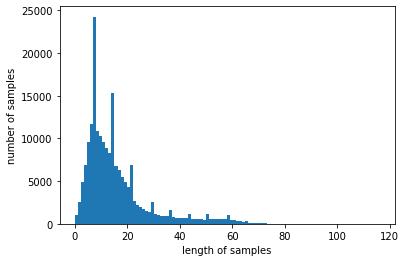

In [6]:
# decoding
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

# 텍스트데이터 문장길이의 리스트를 생성한 후
total_data_text = list(x_train) + list(x_test)

# 문장길이의 평균값, 최대값, 표준편차를 계산
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
plt.clf()

plt.hist([len(s) for s in total_data_text], bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [7]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 가정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))


pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
# padding
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value=word_to_index["<PAD>"],
                                                     padding='pre', # 혹은 'pre'
                                                     maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                    value=word_to_index["<PAD>"],
                                                    padding='pre', # 혹은 'pre'
                                                    maxlen=maxlen)

print(x_train.shape)

(146182, 41)


# RNN

In [9]:
#모델 설계
vocab_size = len(index_to_word)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

In [10]:
RNN_model = tf.keras.Sequential()
RNN_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
RNN_model.add(tf.keras.layers.LSTM(8))
# 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 
# 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
RNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
RNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 9888      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


# CNN

In [11]:
CNN_model = tf.keras.Sequential()
CNN_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(tf.keras.layers.MaxPooling1D(5))
CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(tf.keras.layers.GlobalMaxPooling1D())
CNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
CNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim


CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          33616     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

# GlobalMaxPooling1D

In [12]:
GMP_model = tf.keras.Sequential()
GMP_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(tf.keras.layers.GlobalMaxPooling1D())
GMP_model.add(tf.keras.layers.Dense(8, activation='relu'))
GMP_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

GMP_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2408      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


# validation set 20000분리

In [13]:
# validation set 20000 분리
x_val = x_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지 
partial_x_train = x_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


In [14]:
# 모델학습하기
RNN_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
epochs=10

RNN_history = RNN_model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)
# 평가하기
results = RNN_model.evaluate(x_test, y_test, verbose=2)

print(results)

Epoch 1/10
247/247 [==============================] - 5s 9ms/step - loss: 0.4252 - accuracy: 0.8123 - val_loss: 0.3451 - val_accuracy: 0.8539
Epoch 2/10
247/247 [==============================] - 2s 7ms/step - loss: 0.3161 - accuracy: 0.8667 - val_loss: 0.3293 - val_accuracy: 0.8572
Epoch 3/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2793 - accuracy: 0.8850 - val_loss: 0.3279 - val_accuracy: 0.8595
Epoch 4/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2494 - accuracy: 0.8983 - val_loss: 0.3348 - val_accuracy: 0.8600
Epoch 5/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2229 - accuracy: 0.9103 - val_loss: 0.3525 - val_accuracy: 0.8577
Epoch 6/10
247/247 [==============================] - 2s 7ms/step - loss: 0.1989 - accuracy: 0.9225 - val_loss: 0.3712 - val_accuracy: 0.8525
Epoch 7/10
247/247 [==============================] - 2s 7ms/step - loss: 0.1782 - accuracy: 0.9313 - val_loss: 0.4002 - val_accuracy: 0.8522
Epoch 

In [15]:
# 모델학습하기
CNN_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
epochs=10

CNN_history = CNN_model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)
# 평가하기
results = CNN_model.evaluate(x_test, y_test, verbose=2)

print(results)

Epoch 1/10
247/247 [==============================] - 4s 10ms/step - loss: 0.4332 - accuracy: 0.7910 - val_loss: 0.3363 - val_accuracy: 0.8540
Epoch 2/10
247/247 [==============================] - 2s 8ms/step - loss: 0.2934 - accuracy: 0.8772 - val_loss: 0.3343 - val_accuracy: 0.8548
Epoch 3/10
247/247 [==============================] - 2s 8ms/step - loss: 0.2262 - accuracy: 0.9115 - val_loss: 0.3506 - val_accuracy: 0.8550
Epoch 4/10
247/247 [==============================] - 2s 8ms/step - loss: 0.1533 - accuracy: 0.9444 - val_loss: 0.4030 - val_accuracy: 0.8493
Epoch 5/10
247/247 [==============================] - 2s 8ms/step - loss: 0.0949 - accuracy: 0.9688 - val_loss: 0.4811 - val_accuracy: 0.8444
Epoch 6/10
247/247 [==============================] - 2s 8ms/step - loss: 0.0604 - accuracy: 0.9813 - val_loss: 0.5640 - val_accuracy: 0.8405
Epoch 7/10
247/247 [==============================] - 2s 8ms/step - loss: 0.0428 - accuracy: 0.9872 - val_loss: 0.6427 - val_accuracy: 0.8386
Epoch

In [16]:
# 모델학습하기
GMP_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
epochs=10

GMP_history = GMP_model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)
# 평가하기
results = GMP_model.evaluate(x_test, y_test, verbose=2)

print(results)

Epoch 1/10
247/247 [==============================] - 2s 6ms/step - loss: 0.4571 - accuracy: 0.8128 - val_loss: 0.3417 - val_accuracy: 0.8501
Epoch 2/10
247/247 [==============================] - 1s 5ms/step - loss: 0.3074 - accuracy: 0.8706 - val_loss: 0.3309 - val_accuracy: 0.8549
Epoch 3/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2601 - accuracy: 0.8945 - val_loss: 0.3382 - val_accuracy: 0.8576
Epoch 4/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2175 - accuracy: 0.9156 - val_loss: 0.3500 - val_accuracy: 0.8560
Epoch 5/10
247/247 [==============================] - 1s 5ms/step - loss: 0.1721 - accuracy: 0.9383 - val_loss: 0.3783 - val_accuracy: 0.8533
Epoch 6/10
247/247 [==============================] - 1s 5ms/step - loss: 0.1278 - accuracy: 0.9583 - val_loss: 0.4117 - val_accuracy: 0.8500
Epoch 7/10
247/247 [==============================] - 1s 5ms/step - loss: 0.0870 - accuracy: 0.9755 - val_loss: 0.4523 - val_accuracy: 0.8496
Epoch 

# Loss, Accuracy 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


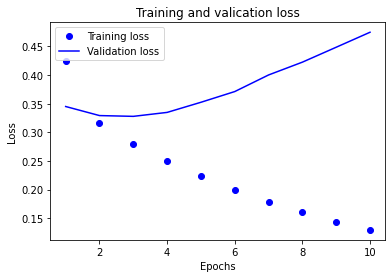

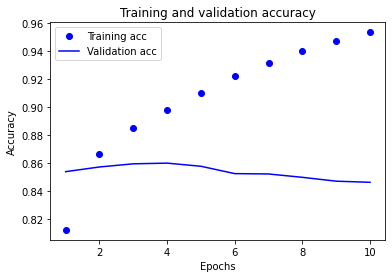

In [17]:
import matplotlib.pyplot as plt
history_dict = RNN_history.history
print(history_dict.keys()) # epoch 에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo는 파란색 점입니다."
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 '파란 실선'입니다.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and valication loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf() # 그림 초기화하기

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


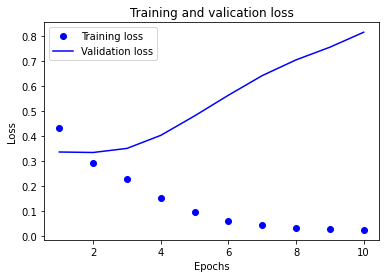

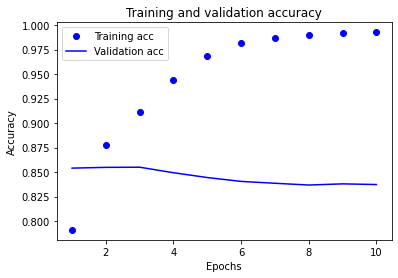

In [18]:
history_dict = CNN_history.history
print(history_dict.keys()) # epoch 에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo는 파란색 점입니다."
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 '파란 실선'입니다.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and valication loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf() # 그림 초기화하기

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


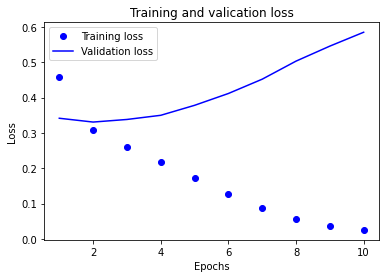

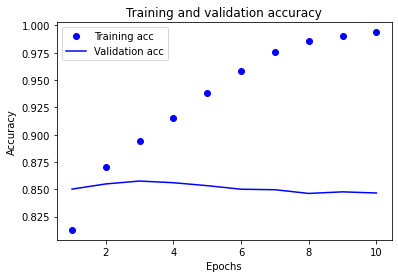

In [19]:
history_dict = GMP_history.history
print(history_dict.keys()) # epoch 에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo는 파란색 점입니다."
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 '파란 실선'입니다.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and valication loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf() # 그림 초기화하기

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 학습된 Embedding 레이어 분석`

In [20]:
! mkdir -p ~/aiffel/sentiment_classification/data
! pip list | grep gensim

gensim                        4.1.2


In [22]:
embedding_layer = CNN_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [24]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = CNN_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [26]:
# , 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있습니다.
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 8.64966065e-02,  5.01053361e-03,  1.65588129e-02, -6.98835496e-03,
        6.19189143e-02,  2.30204482e-02,  1.32733816e-02,  8.94303694e-02,
       -6.46450790e-03,  1.06457239e-02, -4.48079929e-02, -3.11975945e-02,
       -8.53857249e-02, -7.75513425e-02, -1.80125479e-02, -7.73301795e-02,
        1.29275545e-01, -9.05815661e-02, -3.74397822e-02,  9.43919367e-05,
        6.78057894e-02, -2.66176625e-03, -7.56800994e-02, -1.05676558e-02,
        4.60085496e-02,  1.70393963e-03,  1.20330609e-01,  7.43980035e-02,
       -7.01060966e-02,  6.88448474e-02, -5.14654107e-02,  6.34651408e-02,
        3.91494995e-03, -9.11617577e-02,  5.64749949e-02,  1.18167952e-01,
        1.00902636e-02, -3.86013761e-02,  4.34973575e-02, -2.26098485e-02,
        5.91085590e-02,  1.92695223e-02,  4.89138591e-04,  4.82969806e-02,
       -1.56469315e-01, -2.88250986e-02, -1.81440618e-02,  7.54434317e-02,
        4.73109782e-02, -2.22635437e-02,  9.17625576e-02, -8.45729653e-03,
       -7.82406703e-02,  

In [29]:
# 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하는 방법 중에, 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법이 있습니다.
word_vectors.similar_by_word("사랑")

[('다녀온', 0.5676746368408203),
 ('아낌없', 0.5543385148048401),
 ('찡하', 0.5534965395927429),
 ('삭막', 0.5519180297851562),
 ('찡해', 0.5444169640541077),
 ('진진', 0.543106734752655),
 ('위트', 0.5394550561904907),
 ('감사', 0.5377295613288879),
 ('따듯', 0.5368250608444214),
 ('퍼센트', 0.5342167615890503)]

# 한국어 Word2Vec 임베딩 활용하여 성능 개선